# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [21]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


In [8]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 125000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (125000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [10]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [11]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [12]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [14]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(107311, 10)

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

85.8488

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [17]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(107309, 10)


1    90143
0    17166
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
Back in March I ordered four dawn redwoods from a nursery on Ebay, all about 2-3 feet tall.  They arrived bareroot and healthy.  The plan was to plant three in the ground to replace trees uprooted by Katrina.  The fourth was to go into a pot to be trained as bonsai.  All four trees were thriving, but the one in the pot looked like a plant that yearned to join the rest of its family out in the yard, rather than being forested with my bonsai collection.  Clearly, it was going to take time, patience, and training to get it to look like a bonsai.  I decided to put it in the ground and order a Brussels Dawn Redwood.<br /><br />And I'm glad I did.  The Brussels tree is a long 

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
Back in March I ordered four dawn redwoods from a nursery on Ebay, all about 2-3 feet tall.  They arrived bareroot and healthy.  The plan was to plant three in the ground to replace trees uprooted by Katrina.  The fourth was to go into a pot to be trained as bonsai.  All four trees were thriving, but the one in the pot looked like a plant that yearned to join the rest of its family out in the yard, rather than being forested with my bonsai collection.  Clearly, it was going to take time, patience, and training to get it to look like a bonsai.  I decided to put it in the ground and order a Brussels Dawn Redwood.And I'm glad I did.  The Brussels tree is a long way from a s

In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I first had this tea in a restaurant, immediately I tasted the natural sweetness of this tea. It was not a bitter tea,nor was it too sweet. It was like the perfect cup of tea.


In [25]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I first had this tea in a restaurant immediately I tasted the natural sweetness of this tea It was not a bitter tea nor was it too sweet It was like the perfect cup of tea 


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 107309/107309 [00:38<00:00, 2774.42it/s]


In [29]:
preprocessed_reviews[1500]

'first tea restaurant immediately tasted natural sweetness tea not bitter tea nor sweet like perfect cup tea'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [30]:
## Similartly you can do preprocessing for review summary also.

In [31]:
final['Text'] = preprocessed_reviews

In [32]:
#soring the values based on time stamp
final.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
final = final.drop(['ProductId','Id','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1)


In [33]:
y = final['Score']
text = final['Text']

In [34]:
# X_train_1, test_df_1, y_train_1, y_test_1 = train_test_split(final, y, stratify=y, test_size=0.7)
# print(X_train_1.shape)
# print(y_train_1.shape)

X_train, test_df, y_train, y_test = train_test_split(text, y, stratify=y, test_size=0.2)
train_df, cv_df, y, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

print(train_df.shape)
print(y.shape)
print(cv_df.shape)
print(y_cv.shape)

(68677,)
(68677,)
(17170,)
(17170,)


In [35]:
def do_pickling(filename,data):
    with open(filename, "wb") as f:
        pickle.dump(data,f)

In [36]:
do_pickling('y_train.pickle',y)
do_pickling('y_test.pickle',y_test)
do_pickling('y_cv.pickle',y_cv)

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [37]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (107309, 5000)
the number of unique words including both unigrams and bigrams  5000


In [38]:
count_vect = CountVectorizer(ngram_range=(1,3),min_df=10)
bow_feature_train = count_vect.fit_transform(train_df)
bow_feature_test = count_vect.transform(test_df)
bow_feature_cv = count_vect.transform(cv_df)

In [39]:
do_pickling('bow_train.pickle',bow_feature_train)
do_pickling('bow_test.pickle',bow_feature_test)
do_pickling('bow_cv.pickle',bow_feature_cv)
do_pickling('count_vect.pickle',count_vect)

## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [40]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3),min_df=10)
tf_idf_train = tf_idf_vect.fit_transform(train_df)
tf_idf_test = tf_idf_vect.transform(test_df)
tf_idf_cv = tf_idf_vect.transform(cv_df)

In [41]:
do_pickling('tfidf_train.pickle',tf_idf_train)
do_pickling('tfidf_test.pickle',tf_idf_test)
do_pickling('tfidf_cv.pickle',tf_idf_cv)
do_pickling('tf_idf_vect.pickle',tf_idf_vect)

## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [43]:
def findAvgWord2Vec(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
    

In [44]:
def getListOfSentences(values):
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())
    return list_of_sent

In [45]:
list_of_sent = getListOfSentences(train_df.values)
w2v_model=Word2Vec(list_of_sent,min_count=10,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [46]:
sent_vectors_train = findAvgWord2Vec(list_of_sent)

100%|██████████| 68677/68677 [02:01<00:00, 562.99it/s]


In [47]:
do_pickling('avg_w2v_train.pickle',sent_vectors_train)

In [48]:
list_of_sent = getListOfSentences(test_df.values)

In [49]:
sent_vectors_test = findAvgWord2Vec(list_of_sent)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 21462/21462 [00:38<00:00, 557.97it/s]

21462
50


In [50]:
do_pickling('avg_w2v_test.pickle',sent_vectors_test)

In [51]:
list_of_sent= getListOfSentences(cv_df.values)
sent_vectors_cv = findAvgWord2Vec(list_of_sent)

100%|██████████| 17170/17170 [00:31<00:00, 546.21it/s]


In [60]:
do_pickling('avg_w2v_cv.pickle',sent_vectors_cv)

#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [53]:
def findTfidfW2V(values):
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(values)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())
        
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                if(len(word)!=1):
                    vec = w2v_model.wv[word]
                    # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    # to reduce the computation we are 
                    # dictionary[word] = idf value of word in whole courpus
                    # sent.count(word) = tf valeus of word in this review
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [54]:
tfidf_sent_vectors = findTfidfW2V(train_df)
print(len(tfidf_sent_vectors))

100%|██████████| 68677/68677 [02:20<00:00, 490.14it/s]

68677


In [55]:
do_pickling('tfidf_w2v_train.pickle',tfidf_sent_vectors)

In [56]:
tfidf_sent_vectors_test = findTfidfW2V(test_df.values)
print(len(tfidf_sent_vectors_test))

100%|██████████| 21462/21462 [00:43<00:00, 491.38it/s]


21462


In [57]:
do_pickling('tfidf_w2v_test.pickle',tfidf_sent_vectors_test)

In [58]:
tfidf_sent_vectors_cv = findTfidfW2V(cv_df.values)

100%|██████████| 17170/17170 [00:35<00:00, 482.89it/s]


In [59]:
do_pickling('tfidf_w2v_cv.pickle',tfidf_sent_vectors_cv)

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np

import pickle 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics.classification import log_loss
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve

In [3]:
# function to load the pickle data
def loadPickleData(filename):
    pickle_off = open(filename,"rb")
    final = pickle.load(pickle_off)
    return final


In [4]:
# load the y values because they are common across all feature engineering
y_train = loadPickleData('y_train.pickle')
y_test = loadPickleData('y_test.pickle')
y_cv = loadPickleData('y_cv.pickle')

In [5]:
def getImportantFeatures(indices,vectorizer):
    words =[]
    feature_names = vectorizer.get_feature_names()
    for x in indices:
        words.append(feature_names[x])
    return words

In [6]:
def draw_wordcloud(train):
    wordcloud = WordCloud(    background_color='black',
                              width=1600,
                              height=800,
                        ).generate(train)

    fig = plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [7]:
def plotAUC(train_fpr,train_tpr,test_fpr,test_tpr):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(train_fpr, train_tpr,c='g',label="cv")
    ax.plot(test_fpr, test_tpr,c='r',label="train")

    plt.grid()
    ax.set_title("ROC Curve")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")

In [8]:
estimators = [100,200,500,1000,2000]
depth = [1, 5, 10, 50, 100, 500]

In [9]:
# estimators = [100,200]
# depth = [1, 5, 10]

In [10]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [11]:
def drawHeatMap(C,title):
    parameters = {'n_estimators' : estimators,
    'depth' : depth}
    labels_y = parameters['n_estimators']
    labels_x = parameters['depth']
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".6f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel('Depth')
    plt.ylabel('No of estimators')
    plt.title(title)
    plt.show()

In [12]:
def calculateMetricC(X,y,train,y_train):
    auc_array = []
    C = np.zeros((len(estimators),len(depth)))
    for x,i in enumerate(estimators):
        for z,r in enumerate(depth):
            print("for estimator = {} and depth = {}".format(i,r))
            clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=r, random_state=42, n_jobs=-1)
            clf.fit(train, y_train)
            pred = clf.predict(X)
            area = roc_auc_score(y, pred)
            auc_array.append(area)
            print("Area:",area)
            C[x][z]= area   
    return (auc_array,C)

In [13]:
def performHyperParameterTuning(train,cv,test):
    auc_array,C_cv = calculateMetricC(cv,y_cv,train,y_train)
    auc_array_train,C_train = calculateMetricC(train,y_train,train,y_train)
    drawHeatMap(C_cv,'Cross Validation')
    drawHeatMap(C_train,'Train')
    best_alpha = np.argmax(auc_array)
    best_a = estimators[int(best_alpha/6)]
    best_r = depth[int(best_alpha%6)]
    print("best estimators = {} and depth = {}".format(best_a,best_r))
    return (best_a,best_r)

In [14]:
def bestModel(train,cv,test,best_estimator,best_depth):
    clf = RandomForestClassifier(n_estimators=best_estimator, criterion='gini', max_depth=best_depth, random_state=42, n_jobs=-1)
    clf.fit(train, y_train)
    
    predict_y = clf.predict(train)
    plot_confusion_matrix(y_train,predict_y)
    train_fpr,train_tpr , train_thresholds = roc_curve(y_train, predict_y)
    print('For values of best estimator = ',best_estimator,'best depth = ' , best_depth,"The AUC is:",roc_auc_score(y_train, predict_y))
    predict_y = clf.predict(cv)
    print('For values of best estimator = ',best_estimator,'best depth = ' , best_depth, "The AUC is:",roc_auc_score(y_cv, predict_y))
    predict_y = clf.predict(test)
    plot_confusion_matrix(y_test,predict_y)
    test_fpr,test_tpr ,train_thresholds = roc_curve(y_test, predict_y)
    print('For values of best estimator = ',best_estimator,'best depth = ' , best_depth, "The AUC is:",roc_auc_score(y_test, predict_y))
    plotAUC(train_fpr,train_tpr,test_fpr,test_tpr)
    return clf

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [74]:
np.unique(y_cv)

array([0, 1])

In [75]:
train = loadPickleData("bow_train.pickle")
test = loadPickleData('bow_test.pickle')
cv = loadPickleData('bow_cv.pickle')

for estimator = 100 and depth = 1
Area: 0.5
for estimator = 100 and depth = 5
Area: 0.5
for estimator = 100 and depth = 10
Area: 0.5
for estimator = 100 and depth = 50
Area: 0.5415085004710124
for estimator = 100 and depth = 100
Area: 0.604061672821095
for estimator = 100 and depth = 500
Area: 0.6594729058552551
for estimator = 200 and depth = 1
Area: 0.5
for estimator = 200 and depth = 5
Area: 0.5
for estimator = 200 and depth = 10
Area: 0.5
for estimator = 200 and depth = 50
Area: 0.5416905172165529
for estimator = 200 and depth = 100
Area: 0.6002653055285413
for estimator = 200 and depth = 500
Area: 0.6562225887993233
for estimator = 500 and depth = 1
Area: 0.5
for estimator = 500 and depth = 5
Area: 0.5
for estimator = 500 and depth = 10
Area: 0.5
for estimator = 500 and depth = 50
Area: 0.5396103168247355
for estimator = 500 and depth = 100
Area: 0.5992858880977252
for estimator = 500 and depth = 500
Area: 0.6564305899086624
for estimator = 1000 and depth = 1
Area: 0.5
for estimat

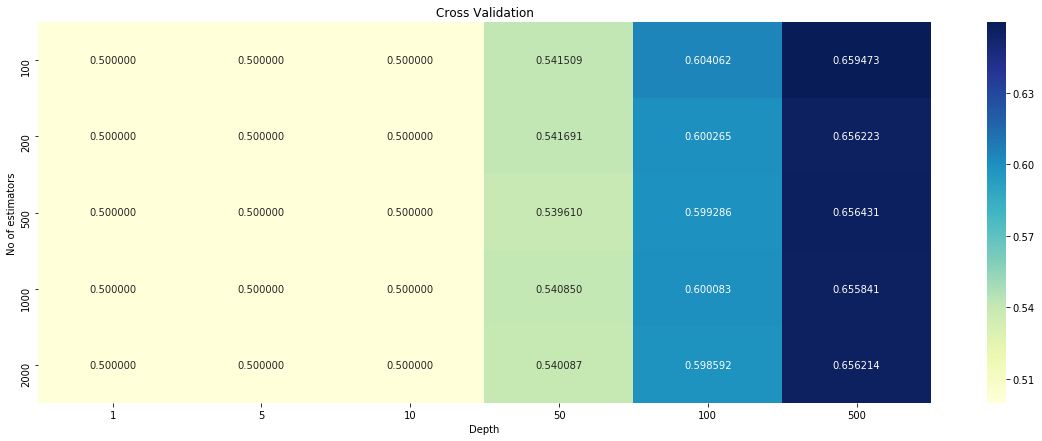

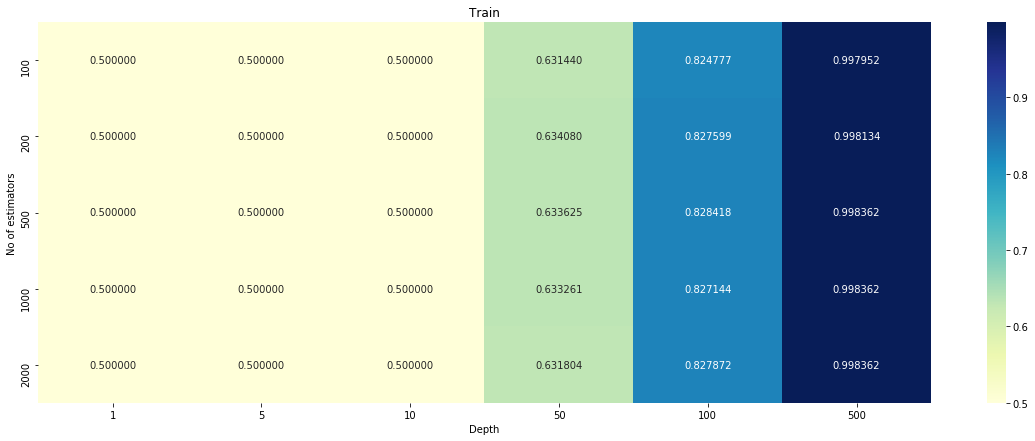

best estimators = 100 and depth = 500


In [76]:
best_estimator,best_depth = performHyperParameterTuning(train,cv,test)

-------------------- Confusion matrix --------------------


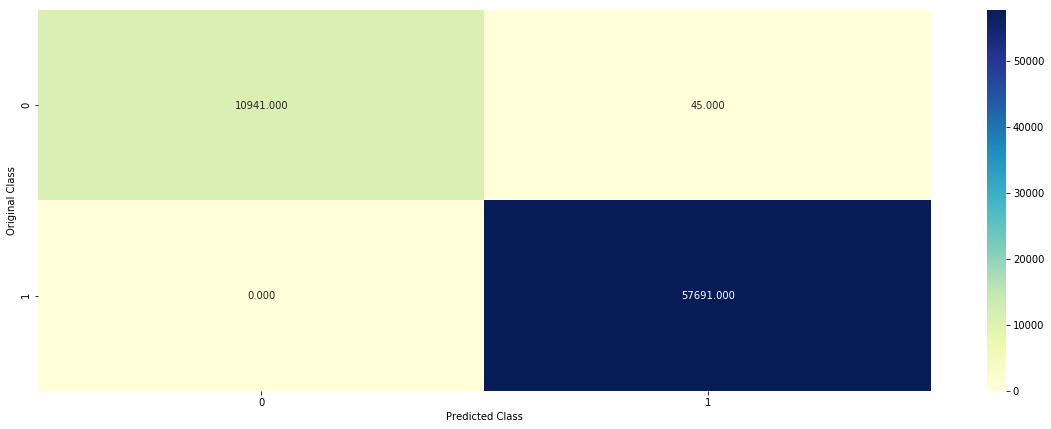

For values of best estimator =  100 best depth =  500 The AUC is: 0.9979519388312398
For values of best estimator =  100 best depth =  500 The AUC is: 0.6594729058552551
-------------------- Confusion matrix --------------------


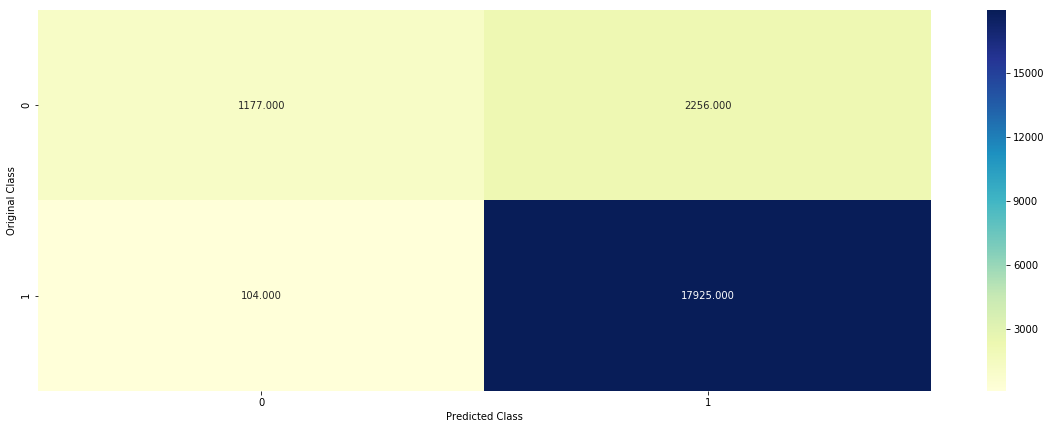

For values of best estimator =  100 best depth =  500 The AUC is: 0.6685401680824388


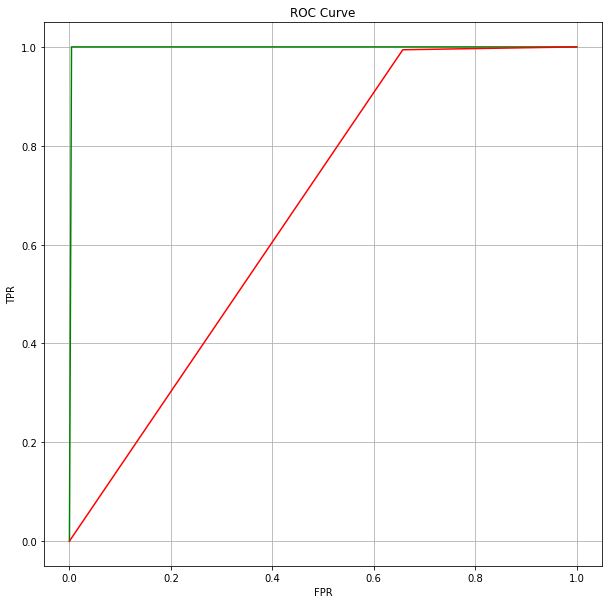

In [77]:
clf = bestModel(train,cv,test,best_estimator,best_depth)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [78]:
indices = np.argsort(-clf.feature_importances_)
word_indices = indices[:20]
words = getImportantFeatures(word_indices,count_vect)
print(words)

['not', 'great', 'disappointed', 'not buy', 'horrible', 'worst', 'not worth', 'waste', 'awful', 'terrible', 'bad', 'return', 'love', 'not recommend', 'best', 'would not', 'threw', 'money', 'waste money', 'disappointing']


In [79]:
text = ''
for word in words:
    text = text+' '+word

In [80]:
print(text)

 not great disappointed not buy horrible worst not worth waste awful terrible bad return love not recommend best would not threw money waste money disappointing


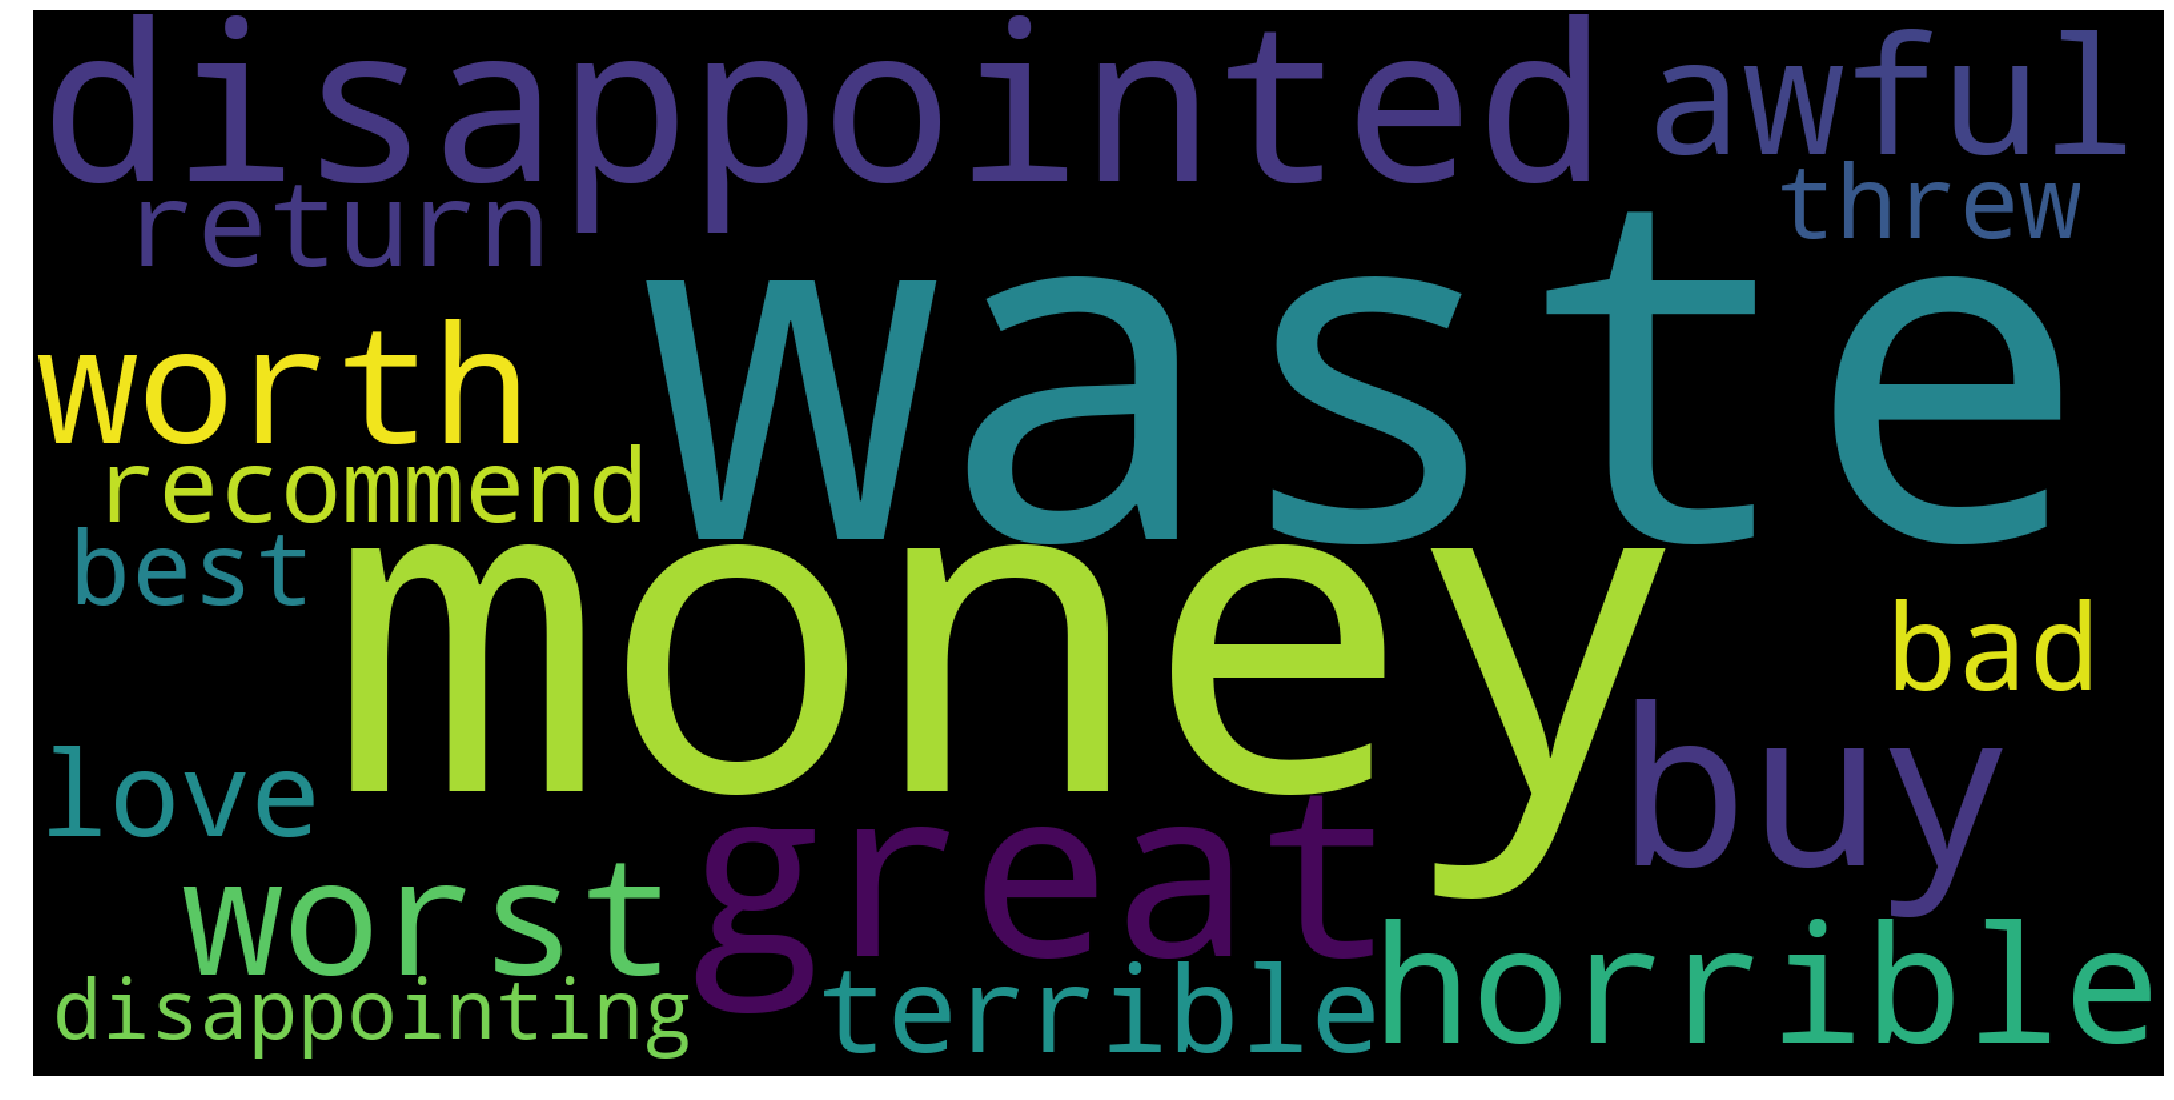

In [81]:
draw_wordcloud(text)

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [82]:
train = loadPickleData("tfidf_train.pickle")
test = loadPickleData('tfidf_test.pickle')
cv = loadPickleData('tfidf_cv.pickle')

In [83]:
tf_idf_vect = loadPickleData('tf_idf_vect.pickle')

for estimator = 100 and depth = 1
Area: 0.5
for estimator = 100 and depth = 5
Area: 0.5
for estimator = 100 and depth = 10
Area: 0.5
for estimator = 100 and depth = 50
Area: 0.5457295524700024
for estimator = 100 and depth = 100
Area: 0.597942437175828
for estimator = 100 and depth = 500
Area: 0.6514554865637113
for estimator = 200 and depth = 1
Area: 0.5
for estimator = 200 and depth = 5
Area: 0.5
for estimator = 200 and depth = 10
Area: 0.5
for estimator = 200 and depth = 50
Area: 0.5438313688237255
for estimator = 200 and depth = 100
Area: 0.5965209700630598
for estimator = 200 and depth = 500
Area: 0.648768521620442
for estimator = 500 and depth = 1
Area: 0.5
for estimator = 500 and depth = 5
Area: 0.5
for estimator = 500 and depth = 10
Area: 0.5
for estimator = 500 and depth = 50
Area: 0.5419765345167632
for estimator = 500 and depth = 100
Area: 0.5921438856823278
for estimator = 500 and depth = 500
Area: 0.6485865048749013
for estimator = 1000 and depth = 1
Area: 0.5
for estimato

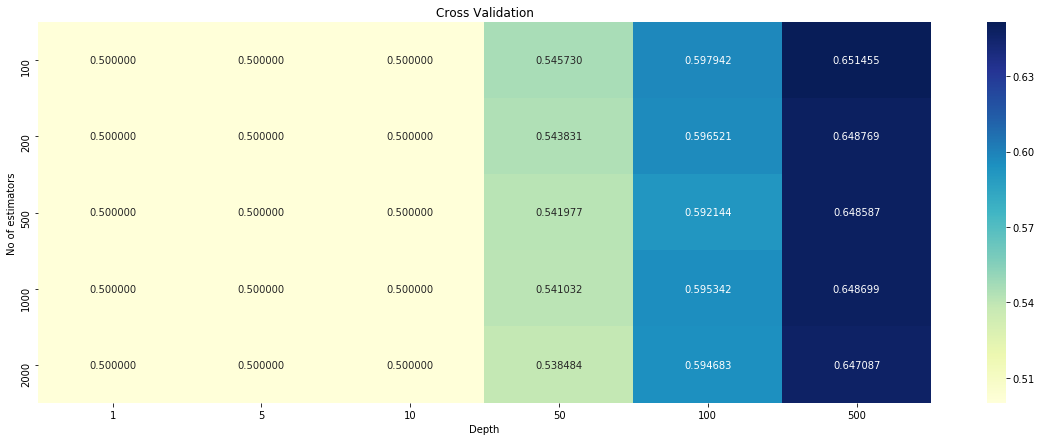

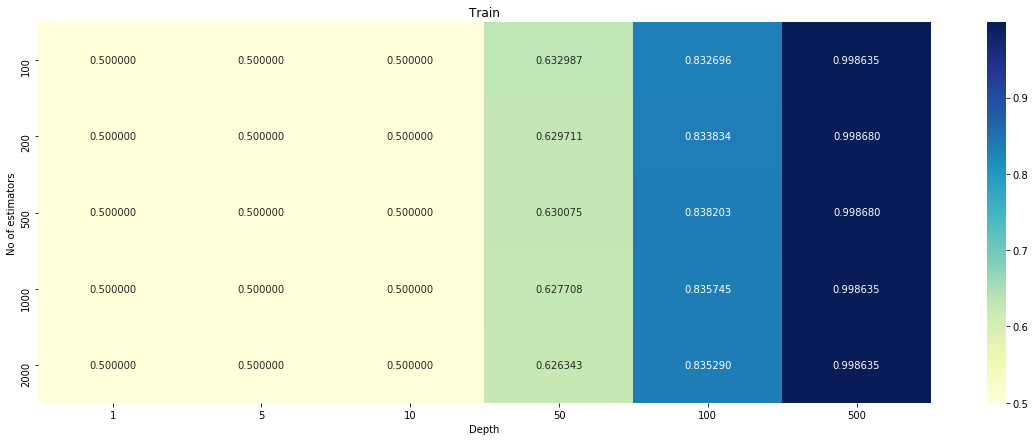

best estimators = 100 and depth = 500


In [84]:
best_estimator,best_depth = performHyperParameterTuning(train,cv,test)

-------------------- Confusion matrix --------------------


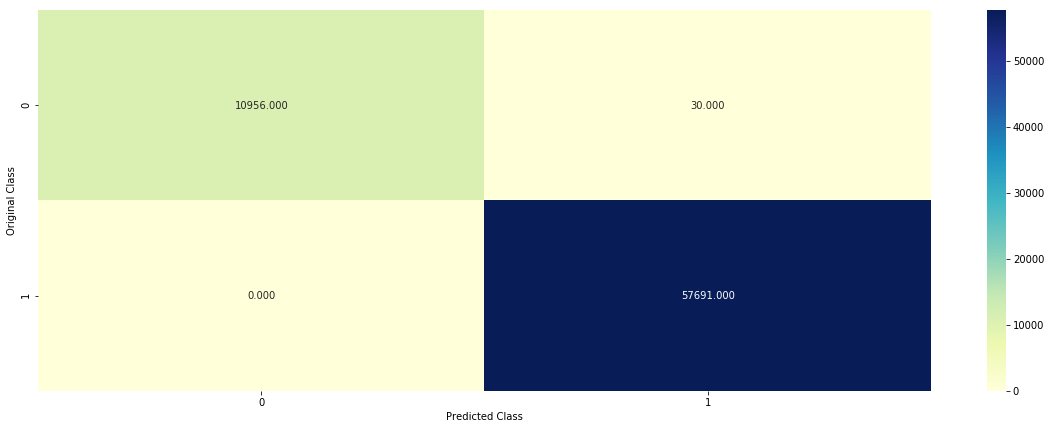

For values of best estimator =  100 best depth =  500 The AUC is: 0.9986346258874932
For values of best estimator =  100 best depth =  500 The AUC is: 0.6514554865637113
-------------------- Confusion matrix --------------------


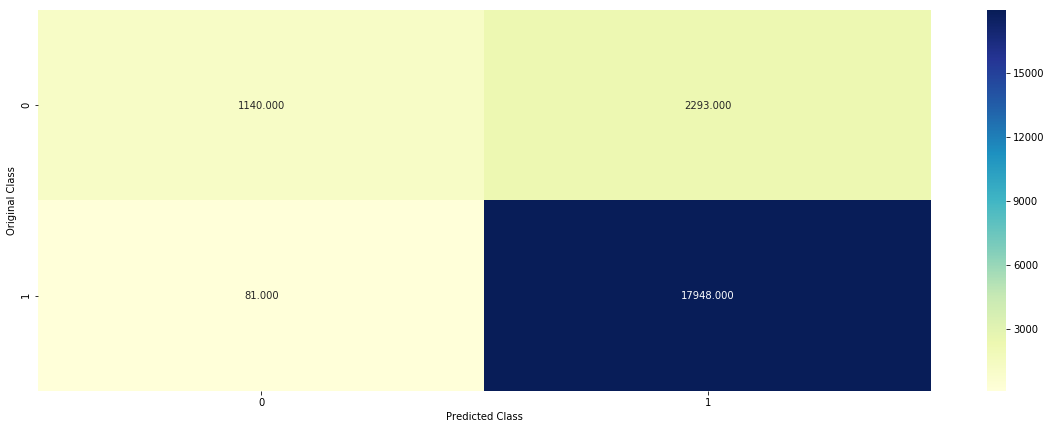

For values of best estimator =  100 best depth =  500 The AUC is: 0.663789156599935


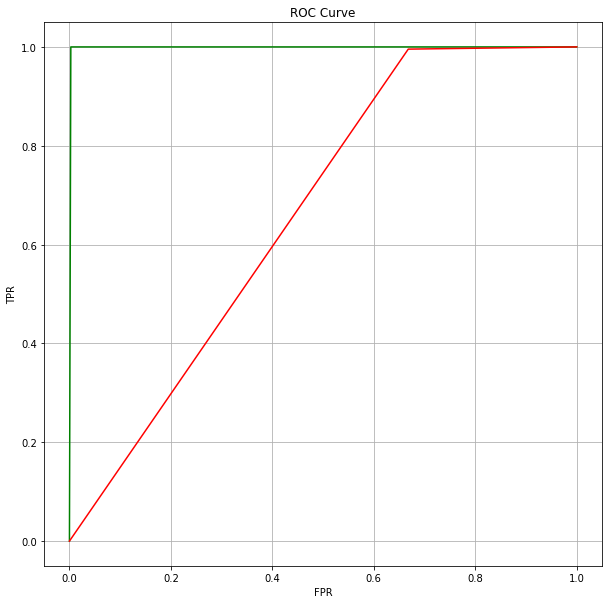

In [85]:
clf = bestModel(train,cv,test,best_estimator,best_depth)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [86]:
# Please write all the code with proper documenindices = np.argsort(-clf.feature_importances_)
word_indices = indices[:20]
words = getImportantFeatures(word_indices,tf_idf_vect)
print(words)

['not', 'great', 'disappointed', 'not buy', 'horrible', 'worst', 'not worth', 'waste', 'awful', 'terrible', 'bad', 'return', 'love', 'not recommend', 'best', 'would not', 'threw', 'money', 'waste money', 'disappointing']


In [87]:
text = ''
for word in words:
    text = text+' '+word

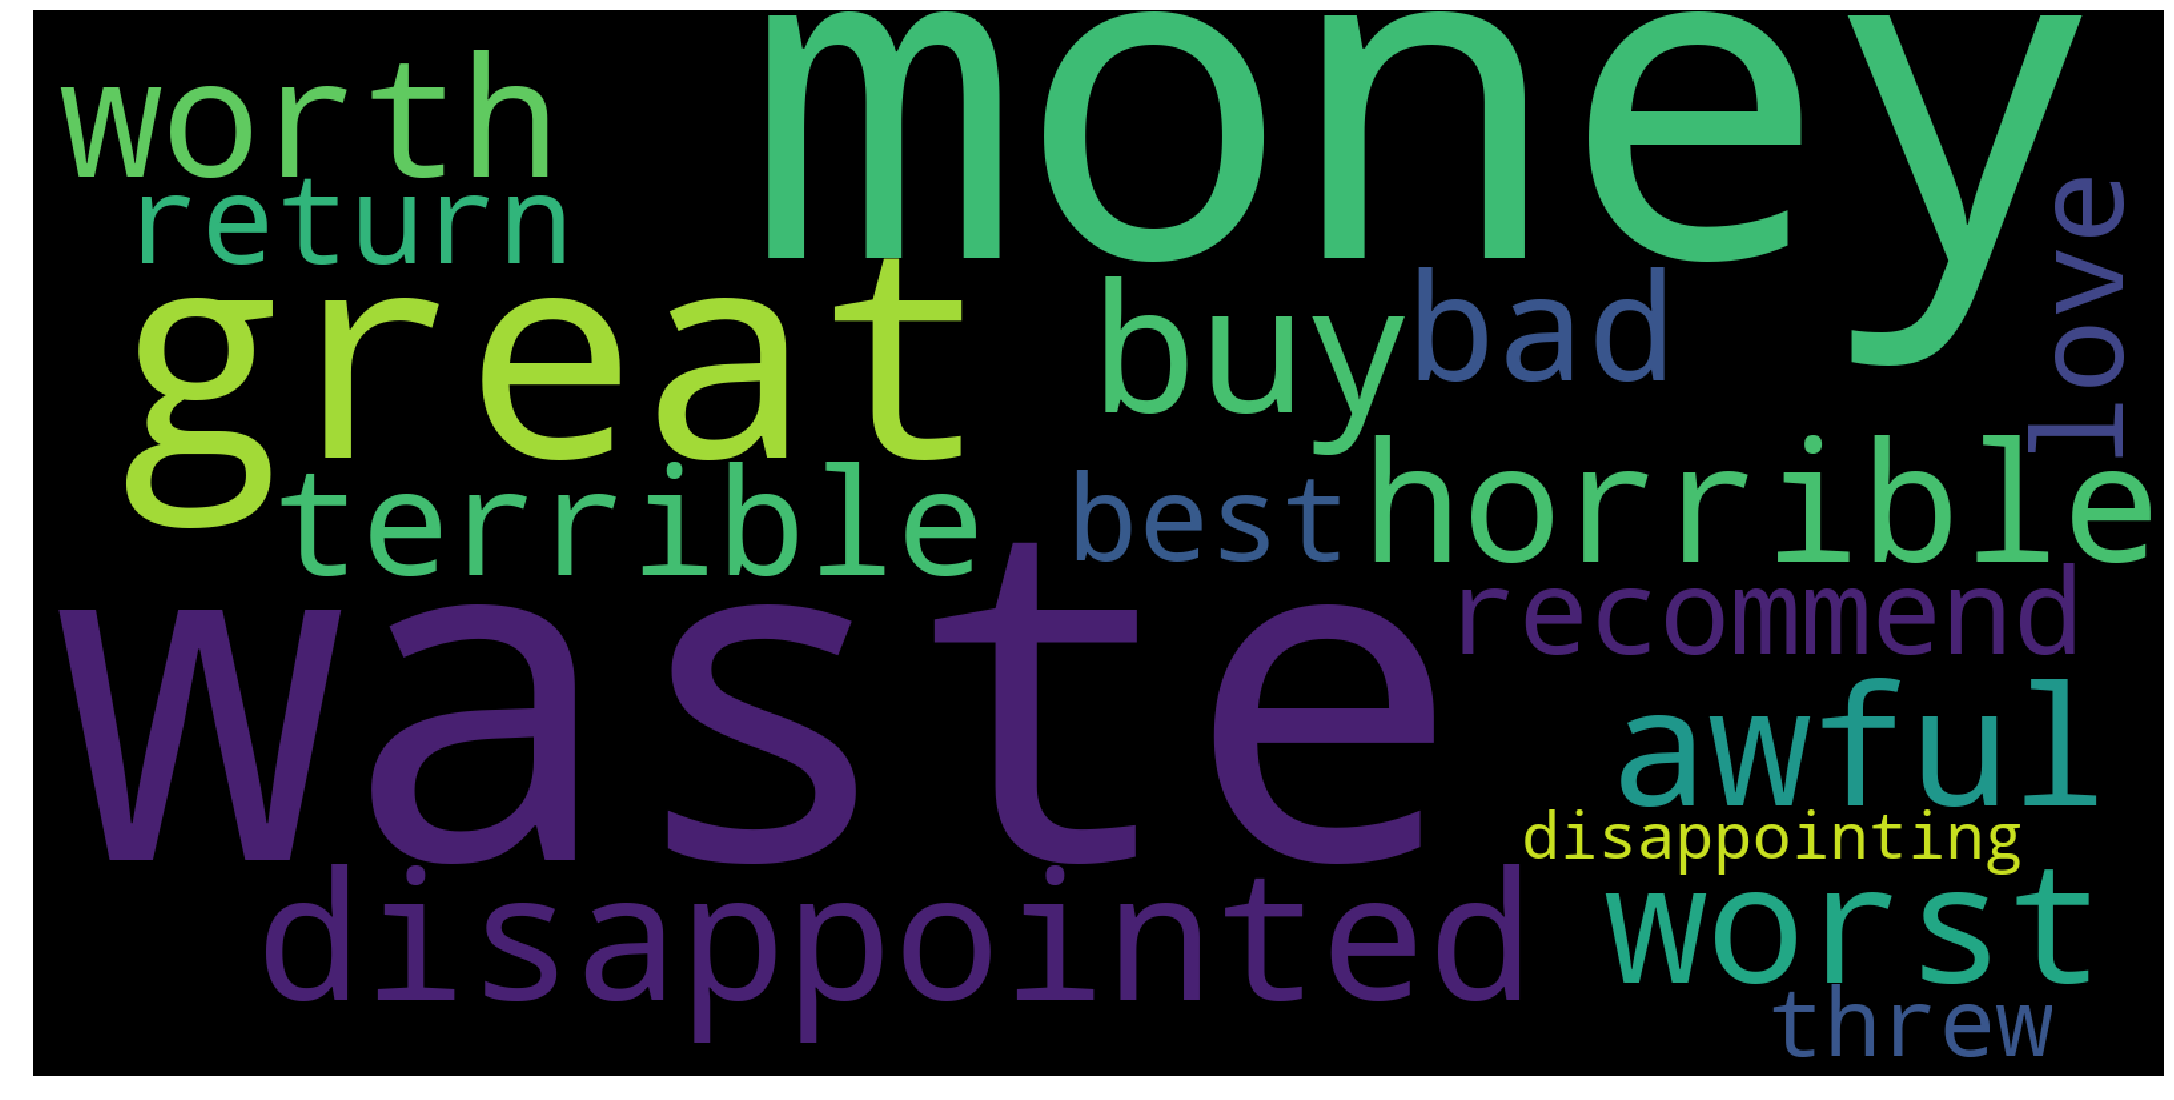

In [88]:
draw_wordcloud(text)

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [89]:
train = loadPickleData("avg_w2v_train.pickle")
test = loadPickleData('avg_w2v_test.pickle')
cv = loadPickleData('avg_w2v_cv.pickle')

for estimator = 100 and depth = 1
Area: 0.5
for estimator = 100 and depth = 5
Area: 0.5018201674554059
for estimator = 100 and depth = 10
Area: 0.5943976727298279
for estimator = 100 and depth = 50
Area: 0.6464461580635286
for estimator = 100 and depth = 100
Area: 0.6464461580635286
for estimator = 100 and depth = 500
Area: 0.6464461580635286
for estimator = 200 and depth = 1
Area: 0.5
for estimator = 200 and depth = 5
Area: 0.5023662176920276
for estimator = 200 and depth = 10
Area: 0.5930455393201729
for estimator = 200 and depth = 50
Area: 0.646420110600255
for estimator = 200 and depth = 100
Area: 0.646420110600255
for estimator = 200 and depth = 500
Area: 0.646420110600255
for estimator = 500 and depth = 1
Area: 0.5
for estimator = 500 and depth = 5
Area: 0.5027302511831089
for estimator = 500 and depth = 10
Area: 0.5947183568815947
for estimator = 500 and depth = 50
Area: 0.6440278454449537
for estimator = 500 and depth = 100
Area: 0.6440278454449537
for estimator = 500 and depth

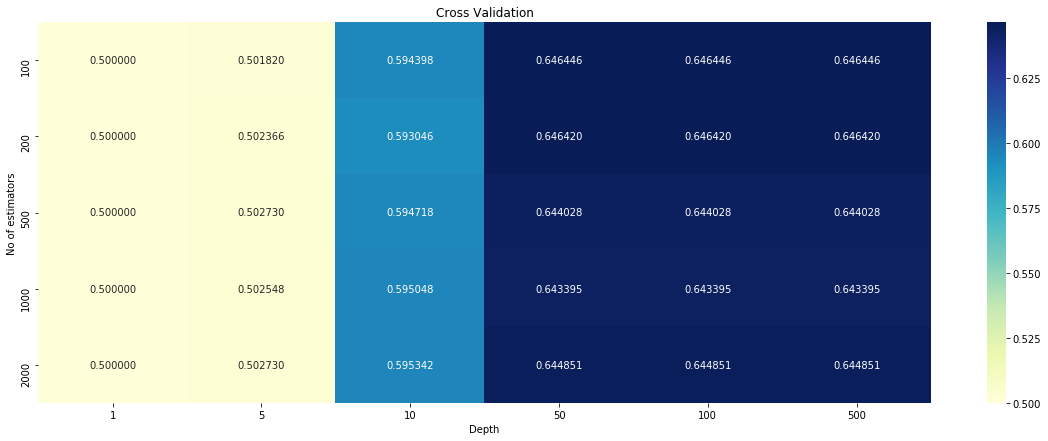

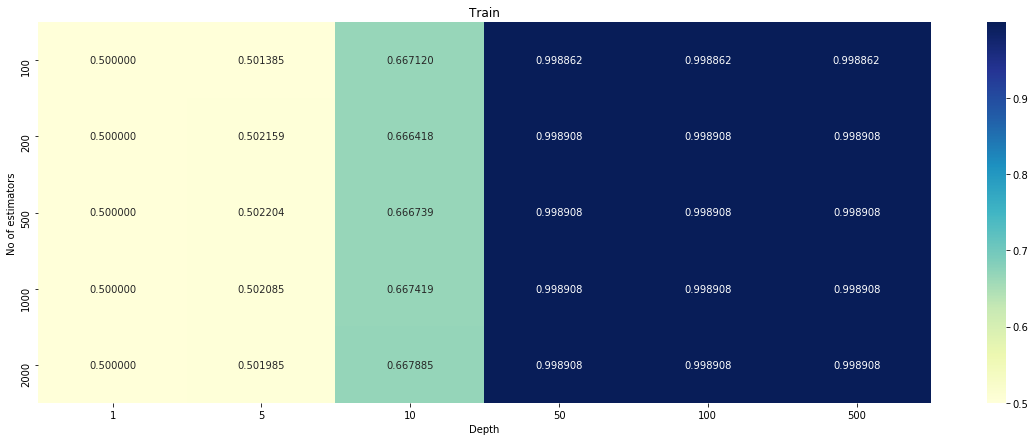

best estimators = 100 and depth = 50


In [90]:
best_estimator,best_depth = performHyperParameterTuning(train,cv,test)

-------------------- Confusion matrix --------------------


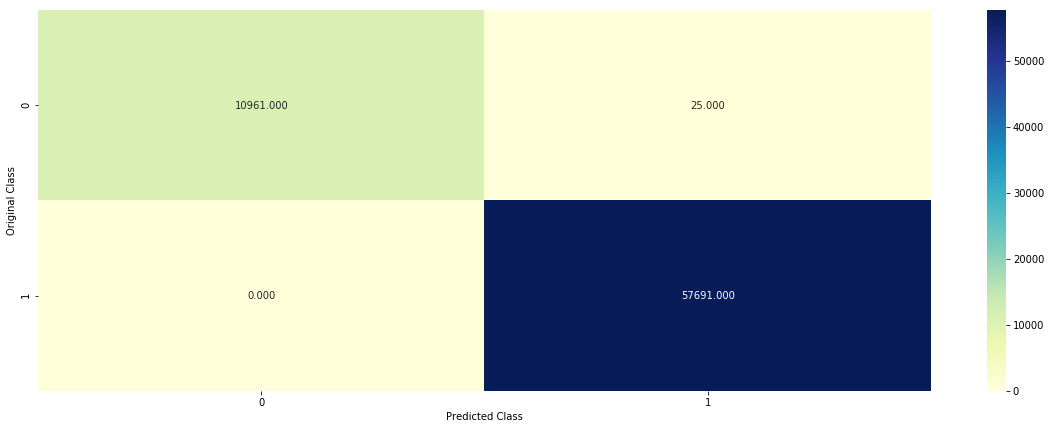

For values of best estimator =  100 best depth =  50 The AUC is: 0.9988621882395776
For values of best estimator =  100 best depth =  50 The AUC is: 0.6464461580635286
-------------------- Confusion matrix --------------------


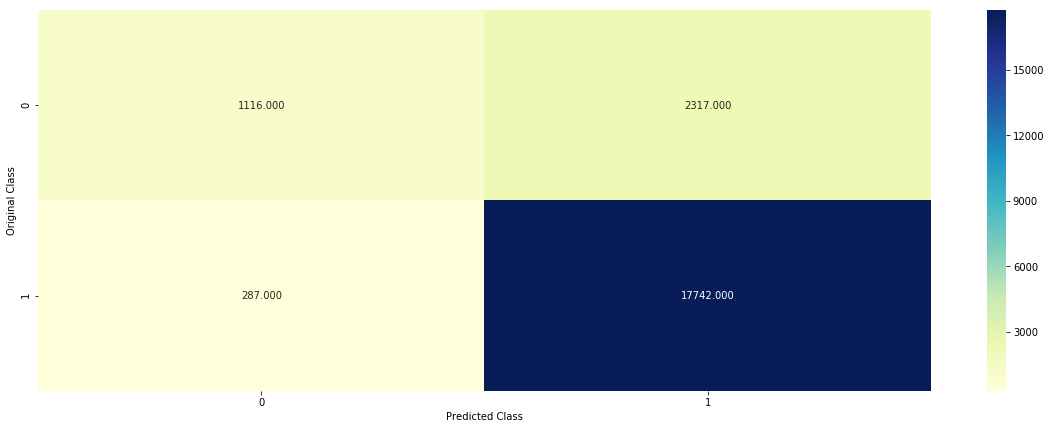

For values of best estimator =  100 best depth =  50 The AUC is: 0.654580653685811


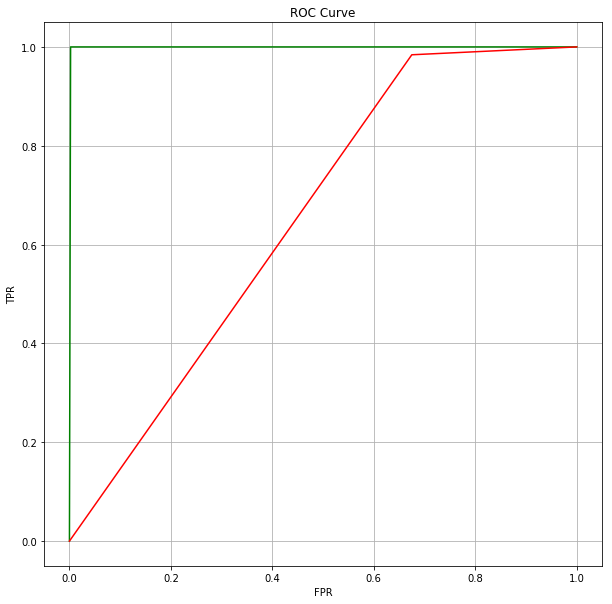

In [91]:
clf = bestModel(train,cv,test,best_estimator,best_depth)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [92]:
train = loadPickleData("tfidf_w2v_train.pickle")
test = loadPickleData('tfidf_w2v_test.pickle')
cv = loadPickleData('tfidf_w2v_cv.pickle')

for estimator = 100 and depth = 1
Area: 0.5
for estimator = 100 and depth = 5
Area: 0.5
for estimator = 100 and depth = 10
Area: 0.5690626151486544
for estimator = 100 and depth = 50
Area: 0.619914936354967
for estimator = 100 and depth = 100
Area: 0.619914936354967
for estimator = 100 and depth = 500
Area: 0.619914936354967
for estimator = 200 and depth = 1
Area: 0.5
for estimator = 200 and depth = 5
Area: 0.5001820167455406
for estimator = 200 and depth = 10
Area: 0.5689932814455414
for estimator = 200 and depth = 50
Area: 0.6177827041360773
for estimator = 200 and depth = 100
Area: 0.6177827041360773
for estimator = 200 and depth = 500
Area: 0.6177827041360773
for estimator = 500 and depth = 1
Area: 0.5
for estimator = 500 and depth = 5
Area: 0.5003640334910812
for estimator = 500 and depth = 10
Area: 0.5681525314209515
for estimator = 500 and depth = 50
Area: 0.6162052046415671
for estimator = 500 and depth = 100
Area: 0.6162052046415671
for estimator = 500 and depth = 500
Area: 0.

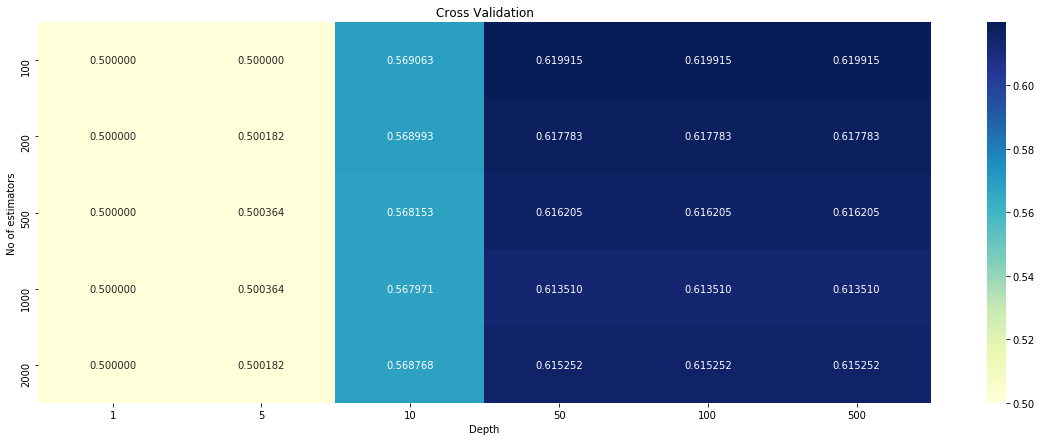

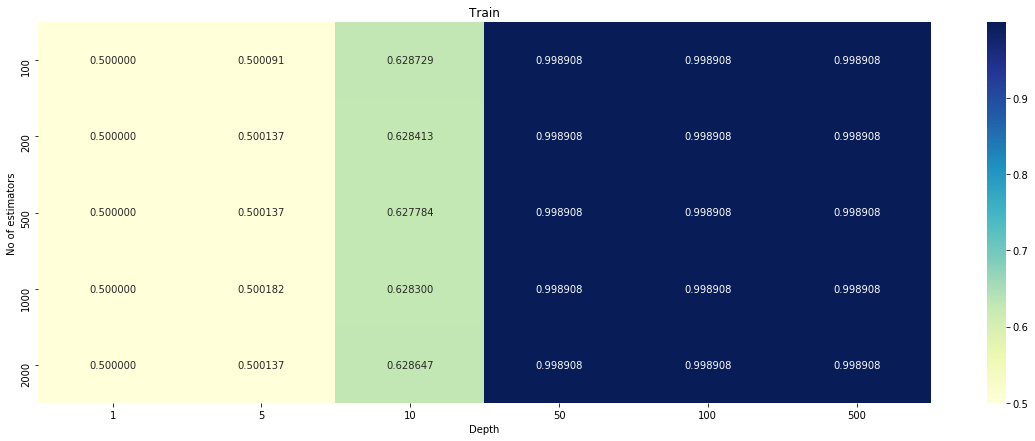

best estimators = 100 and depth = 50


In [93]:
best_estimator,best_depth = performHyperParameterTuning(train,cv,test)

-------------------- Confusion matrix --------------------


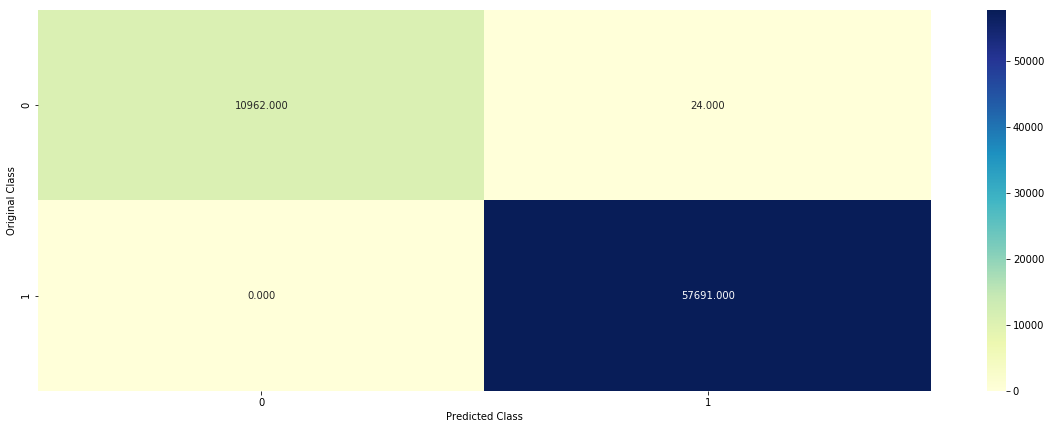

For values of best estimator =  100 best depth =  50 The AUC is: 0.9989077007099945
For values of best estimator =  100 best depth =  50 The AUC is: 0.619914936354967
-------------------- Confusion matrix --------------------


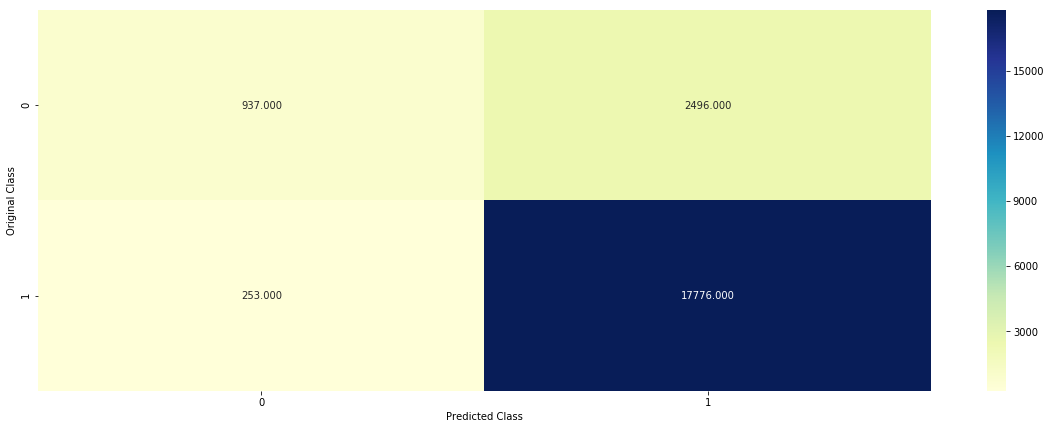

For values of best estimator =  100 best depth =  50 The AUC is: 0.6294530866920445


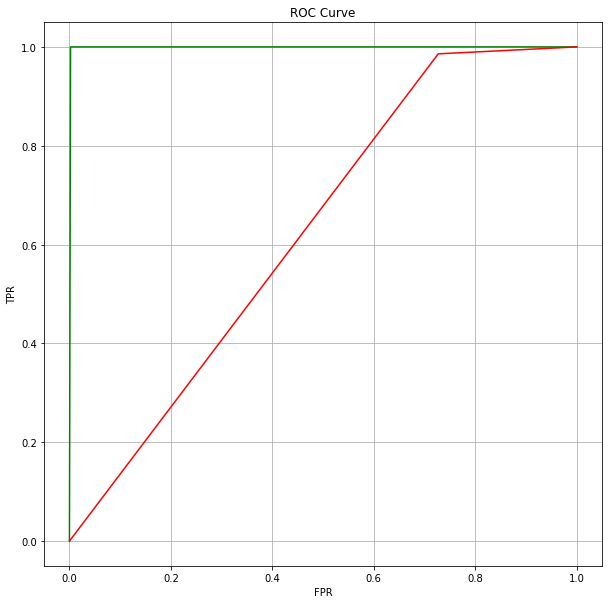

In [94]:
clf = bestModel(train,cv,test,best_estimator,best_depth)

## [5.2] Applying GBDT using XGBOOST

In [15]:
def calculateMetricX(X,y,train,y_train):
    auc_array = []
    C = np.zeros((len(estimators),len(depth)))
    for x,i in enumerate(estimators):
        for z,r in enumerate(depth):
            print("for estimator = {} and depth = {}".format(i,r))
            clf =XGBClassifier(n_estimators=i,max_depth=r)
            clf.fit(train,y_train)
            pred = clf.predict(X)
            area = roc_auc_score(y, pred)
            auc_array.append(area)
            print("Area:",area)
            C[x][z]= area   
    return (auc_array,C)

In [16]:
def bestModelX(train,cv,test,best_estimator,best_depth):
    clf =XGBClassifier(n_estimators=best_estimator,max_depth=best_depth)
    clf.fit(train, y_train)
    
    predict_y = clf.predict(train)
    plot_confusion_matrix(y_train,predict_y)
    train_fpr,train_tpr , train_thresholds = roc_curve(y_train, predict_y)
    print('For values of best estimator = ',best_estimator,'best depth = ' , best_depth,"The AUC is:",roc_auc_score(y_train, predict_y))
    predict_y = clf.predict(cv)
    print('For values of best estimator = ',best_estimator,'best depth = ' , best_depth, "The AUC is:",roc_auc_score(y_cv, predict_y))
    predict_y = clf.predict(test)
    plot_confusion_matrix(y_test,predict_y)
    test_fpr,test_tpr ,train_thresholds = roc_curve(y_test, predict_y)
    print('For values of best estimator = ',best_estimator,'best depth = ' , best_depth, "The AUC is:",roc_auc_score(y_test, predict_y))
    plotAUC(train_fpr,train_tpr,test_fpr,test_tpr)
    return clf

In [17]:
def performHyperParameterTuningX(train,cv,test):
    auc_array,C_cv = calculateMetricX(cv,y_cv,train,y_train)
    auc_array_train,C_train = calculateMetricX(train,y_train,train,y_train)
    drawHeatMap(C_cv,'Cross Validation')
    drawHeatMap(C_train,'Train')
    best_alpha = np.argmax(auc_array)
    best_a = estimators[int(best_alpha/5)]
    best_r = depth[int(best_alpha%5)]
    print("best estimators = {} and depth = {}".format(best_a,best_r))
    return (best_a,best_r)

In [18]:
# if estimator size is of 1000,2000 then the time taking is too long, so limited myself to it.
# TODO - train with 1000,2000 later with better machine
estimators = [100,200,500]
depth = [1, 5, 10, 50, 100]

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [123]:
train = loadPickleData("bow_train.pickle")
test = loadPickleData('bow_test.pickle')
cv = loadPickleData('bow_cv.pickle')

for estimator = 100 and depth = 1
Area: 0.5300241436259144
for estimator = 100 and depth = 5
Area: 0.6662943503178358
for estimator = 100 and depth = 10
Area: 0.7198855420955401
for estimator = 100 and depth = 50
Area: 0.7682502169801647
for estimator = 100 and depth = 100
Area: 0.7718819956021685
for estimator = 200 and depth = 1
Area: 0.5746703412099062
for estimator = 200 and depth = 5
Area: 0.7162104772336968
for estimator = 200 and depth = 10
Area: 0.7661179216617999
for estimator = 200 and depth = 50
Area: 0.7910456595120527
for estimator = 200 and depth = 100
Area: 0.7945994219431857
for estimator = 500 and depth = 1
Area: 0.6385497888047952
for estimator = 500 and depth = 5
Area: 0.7747333599175628
for estimator = 500 and depth = 10
Area: 0.8026773662511348
for estimator = 500 and depth = 50
Area: 0.8105474987481696
for estimator = 500 and depth = 100
Area: 0.8059451744815325
for estimator = 100 and depth = 1
Area: 0.5291302507341329
for estimator = 100 and depth = 5
Area: 0.69

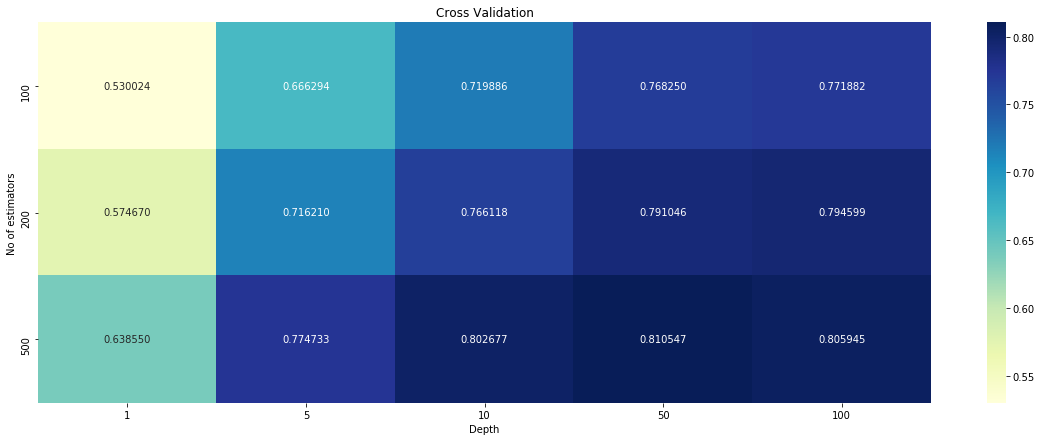

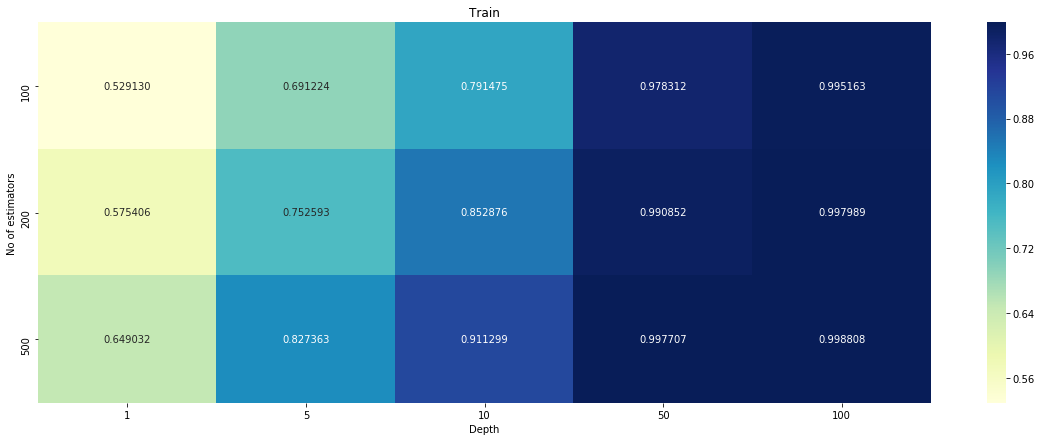

best estimators = 500 and depth = 5


In [124]:
best_estimator,best_depth = performHyperParameterTuningX(train,cv,test)

-------------------- Confusion matrix --------------------


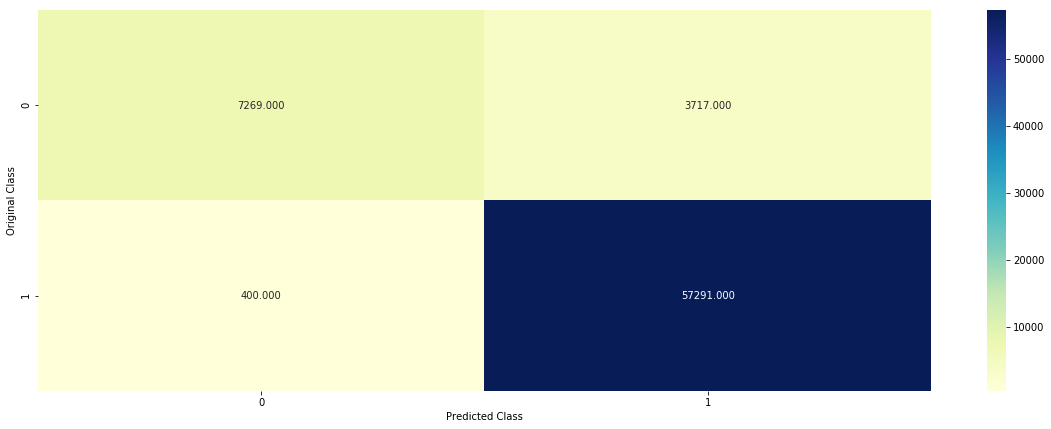

For values of best estimator =  500 best depth =  5 The AUC is: 0.8273634022141787
For values of best estimator =  500 best depth =  5 The AUC is: 0.7747333599175628
-------------------- Confusion matrix --------------------


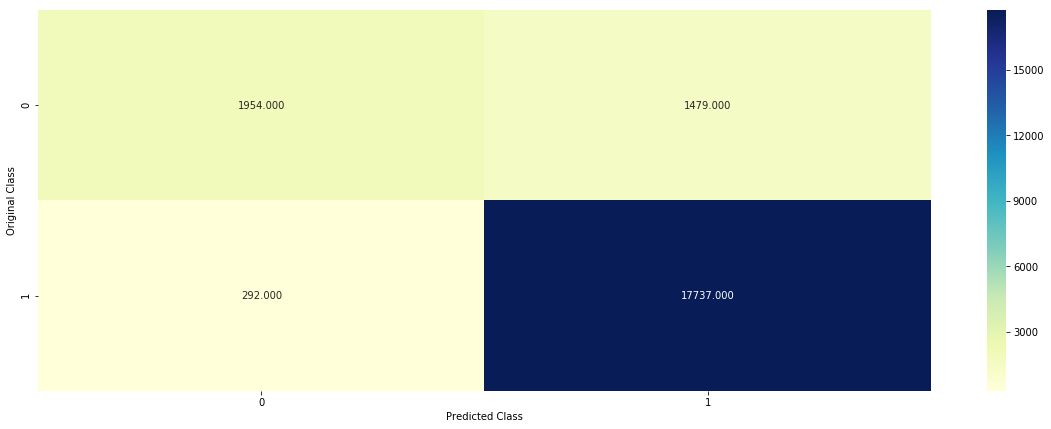

For values of best estimator =  500 best depth =  5 The AUC is: 0.776492672734902


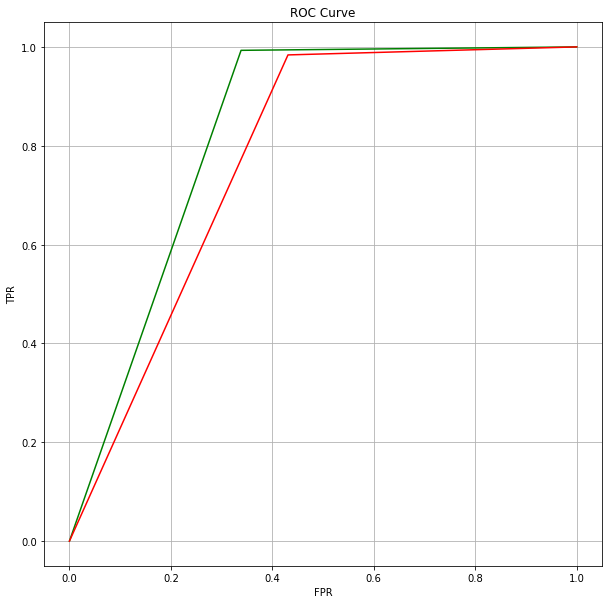

In [125]:
clf = bestModelX(train,cv,test,best_estimator,best_depth)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [22]:
train = loadPickleData("tfidf_train.pickle")
test = loadPickleData('tfidf_test.pickle')
cv = loadPickleData('tfidf_cv.pickle')

for estimator = 100 and depth = 1
Area: 0.53701011365957
for estimator = 100 and depth = 5
Area: 0.6661556829116096
for estimator = 100 and depth = 10
Area: 0.7194261274380722
for estimator = 100 and depth = 50
Area: 0.762330363055954
for estimator = 100 and depth = 100
Area: 0.7654593776811756
for estimator = 200 and depth = 1
Area: 0.5776693078171844
for estimator = 200 and depth = 5
Area: 0.7164791926578662
for estimator = 200 and depth = 10
Area: 0.7606227524440257
for estimator = 200 and depth = 50
Area: 0.7789632206032608
for estimator = 200 and depth = 100
Area: 0.7808614673490125
for estimator = 500 and depth = 1
Area: 0.6460297772480001
for estimator = 500 and depth = 5
Area: 0.7723151734979379
for estimator = 500 and depth = 10
Area: 0.7946252801080345
for estimator = 500 and depth = 50
Area: 0.7973989437299327
for estimator = 500 and depth = 100
Area: 0.7906817522199215
for estimator = 100 and depth = 1
Area: 0.5351118504835755
for estimator = 100 and depth = 5
Area: 0.70022

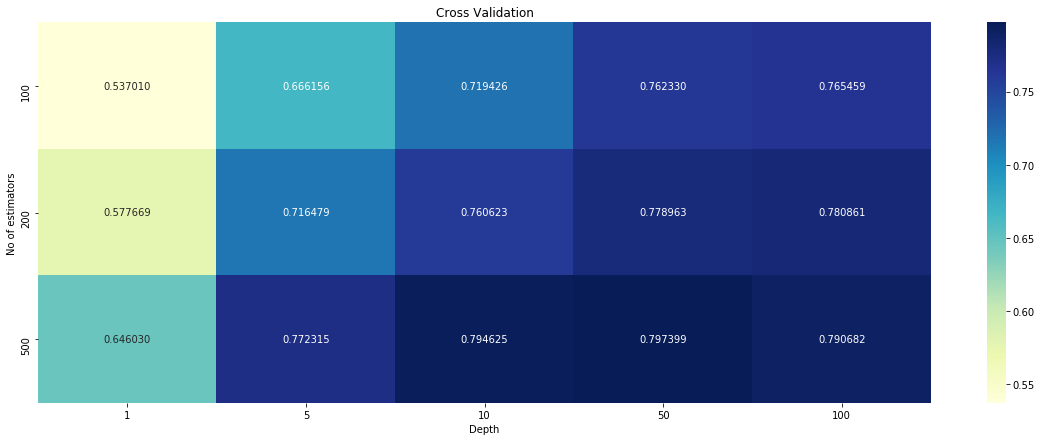

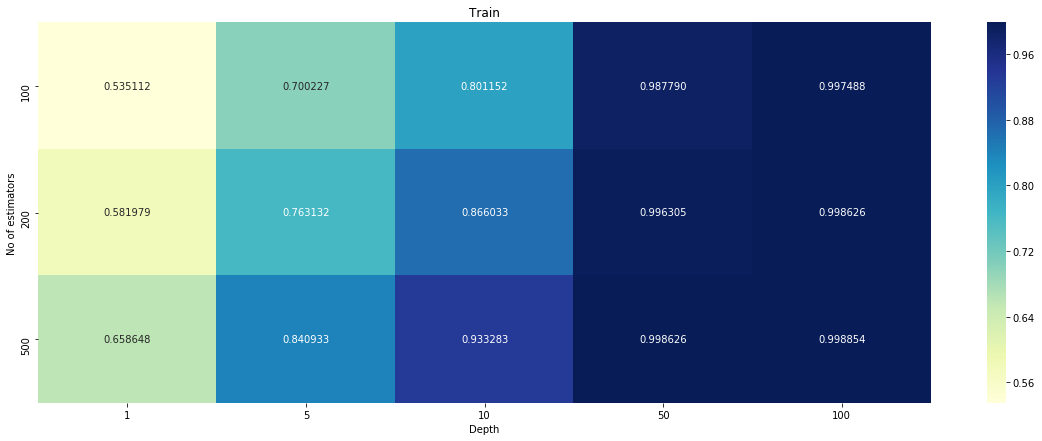

best estimators = 500 and depth = 50


In [23]:
best_estimator,best_depth = performHyperParameterTuningX(train,cv,test)

-------------------- Confusion matrix --------------------


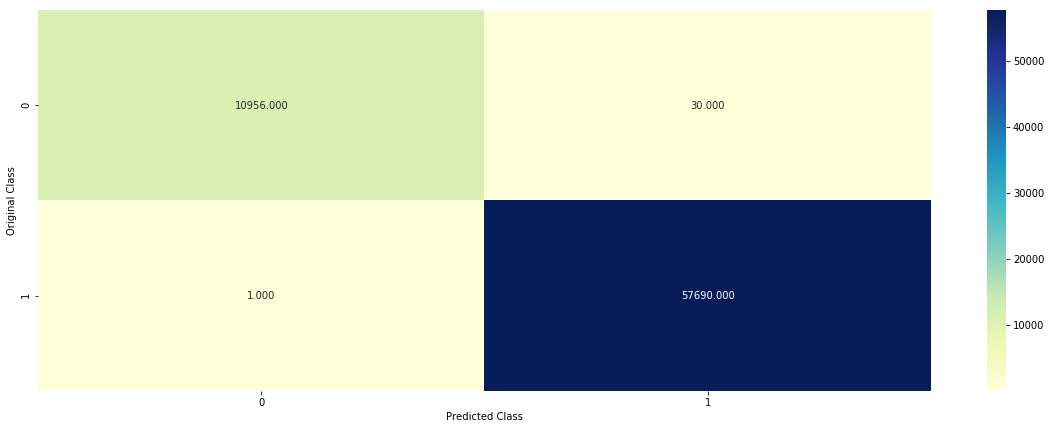

For values of best estimator =  500 best depth =  50 The AUC is: 0.9986259590243777
For values of best estimator =  500 best depth =  50 The AUC is: 0.7973989437299327
-------------------- Confusion matrix --------------------


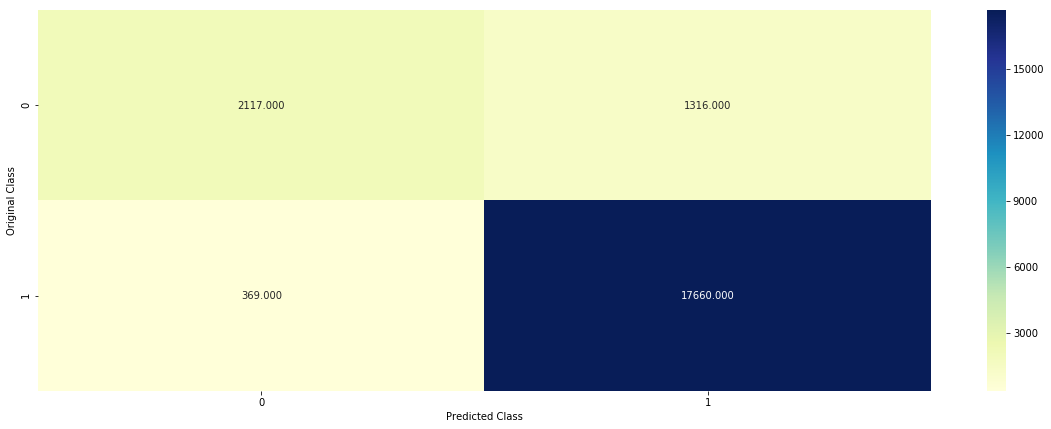

For values of best estimator =  500 best depth =  50 The AUC is: 0.7980973932391703


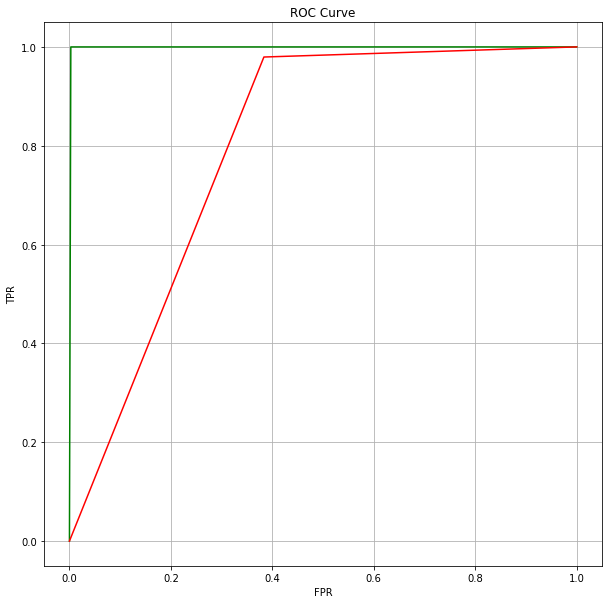

In [24]:
clf = bestModelX(train,cv,test,best_estimator,best_depth)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [30]:
train = loadPickleData("avg_w2v_train.pickle")
test = loadPickleData('avg_w2v_test.pickle')
cv = loadPickleData('avg_w2v_cv.pickle')

In [31]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)
cv = pd.DataFrame(cv)

for estimator = 100 and depth = 1
Area: 0.5209579732004415
for estimator = 100 and depth = 5
Area: 0.7054721202415518
for estimator = 100 and depth = 10
Area: 0.7189934543381027
for estimator = 100 and depth = 50
Area: 0.7041459080962205
for estimator = 100 and depth = 100
Area: 0.7041459080962205
for estimator = 200 and depth = 1
Area: 0.5879317685689955
for estimator = 200 and depth = 5
Area: 0.7275830344290171
for estimator = 200 and depth = 10
Area: 0.7226684561004711
for estimator = 200 and depth = 50
Area: 0.7156823598678657
for estimator = 200 and depth = 100
Area: 0.7156823598678657
for estimator = 500 and depth = 1
Area: 0.6531895863352383
for estimator = 500 and depth = 5
Area: 0.7341964146827834
for estimator = 500 and depth = 10
Area: 0.7302871750493772
for estimator = 500 and depth = 50
Area: 0.7225210431070122
for estimator = 500 and depth = 100
Area: 0.7225210431070122
for estimator = 100 and depth = 1
Area: 0.5225244995716474
for estimator = 100 and depth = 5
Area: 0.75

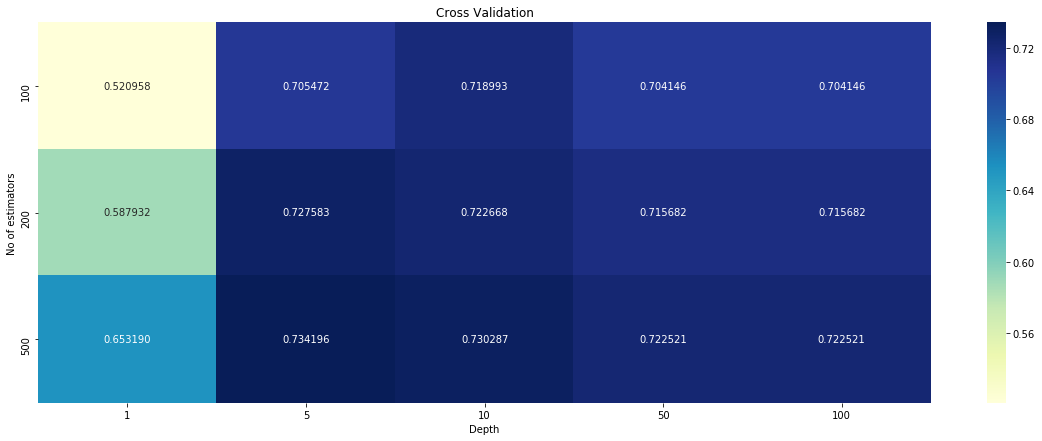

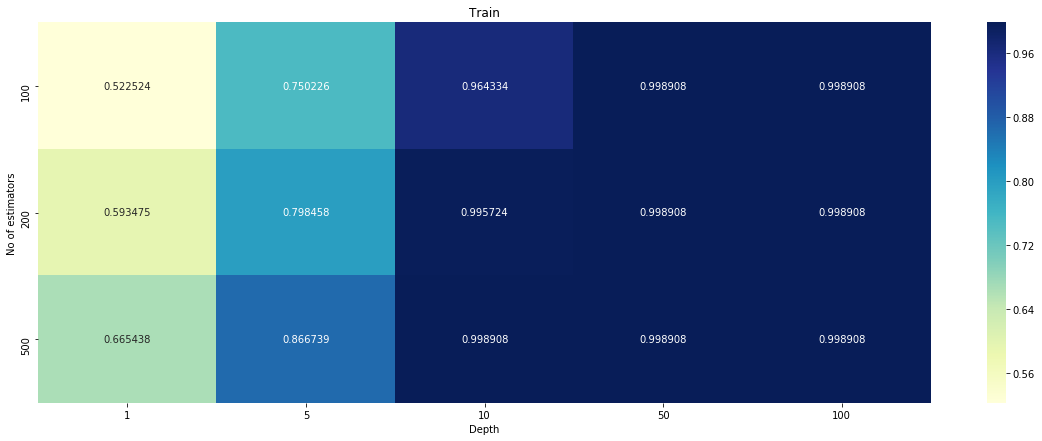

best estimators = 500 and depth = 5


In [32]:
best_estimator,best_depth = performHyperParameterTuningX(train,cv,test)

-------------------- Confusion matrix --------------------


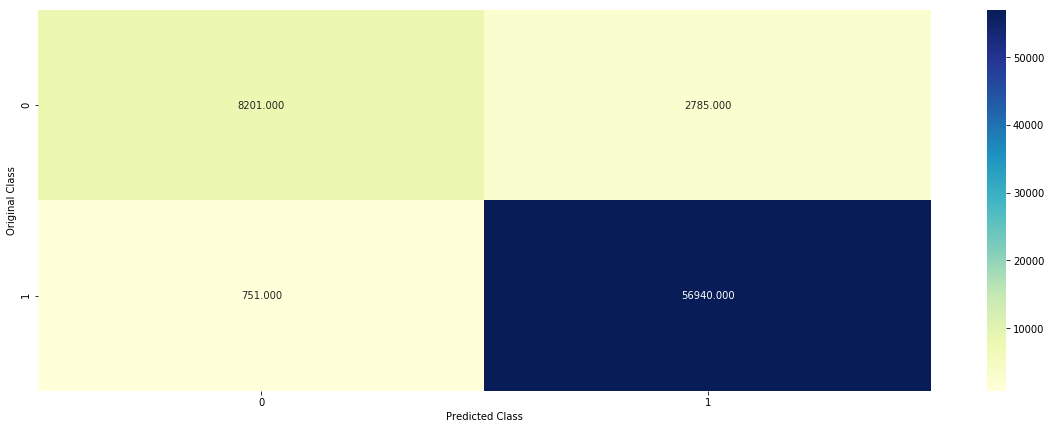

For values of best estimator =  500 best depth =  5 The AUC is: 0.8667389556891612
For values of best estimator =  500 best depth =  5 The AUC is: 0.7341964146827834
-------------------- Confusion matrix --------------------


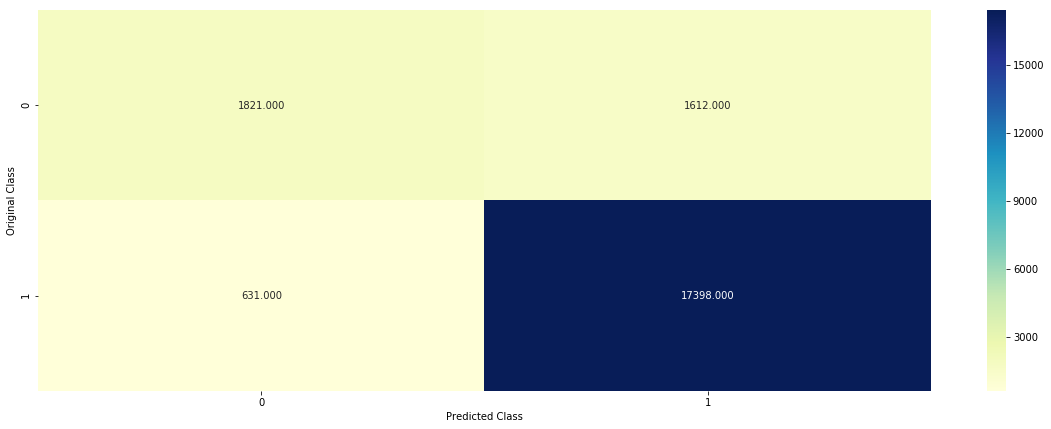

For values of best estimator =  500 best depth =  5 The AUC is: 0.7477203402609419


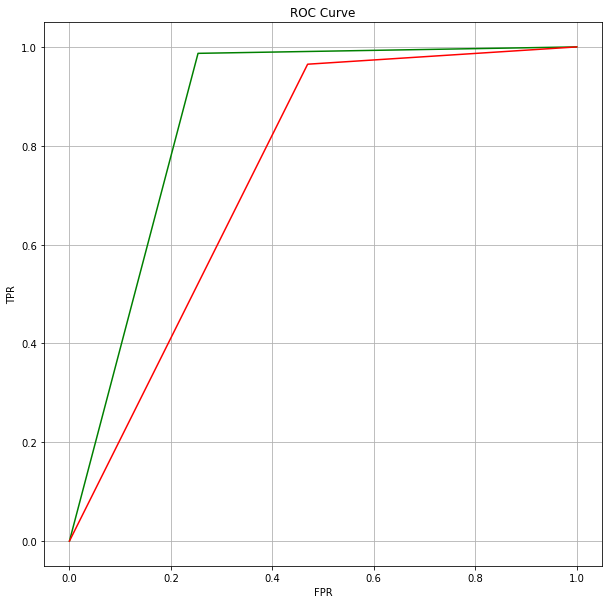

In [33]:
clf = bestModelX(train,cv,test,best_estimator,best_depth)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [34]:
# Please write all the code with proper documentation
train = loadPickleData("tfidf_w2v_train.pickle")
test = loadPickleData('tfidf_w2v_test.pickle')
cv = loadPickleData('tfidf_w2v_cv.pickle')

In [35]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)
cv = pd.DataFrame(cv)

for estimator = 100 and depth = 1
Area: 0.5062319186876945
for estimator = 100 and depth = 5
Area: 0.6616320058305933
for estimator = 100 and depth = 10
Area: 0.6830840605400593
for estimator = 100 and depth = 50
Area: 0.671547545668939
for estimator = 100 and depth = 100
Area: 0.671547545668939
for estimator = 200 and depth = 1
Area: 0.5523256939472031
for estimator = 200 and depth = 5
Area: 0.6865771717558371
for estimator = 200 and depth = 10
Area: 0.68900391446427
for estimator = 200 and depth = 50
Area: 0.6800763483455482
for estimator = 200 and depth = 100
Area: 0.6800763483455482
for estimator = 500 and depth = 1
Area: 0.6129463943963023
for estimator = 500 and depth = 5
Area: 0.7030454406325939
for estimator = 500 and depth = 10
Area: 0.6963799654522803
for estimator = 500 and depth = 50
Area: 0.689073185067908
for estimator = 500 and depth = 100
Area: 0.689073185067908
for estimator = 100 and depth = 1
Area: 0.5061268955362903
for estimator = 100 and depth = 5
Area: 0.71079018

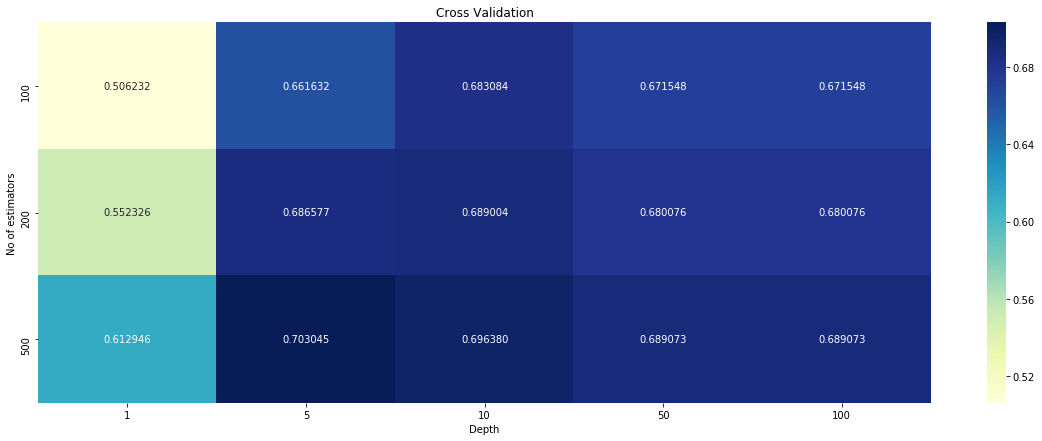

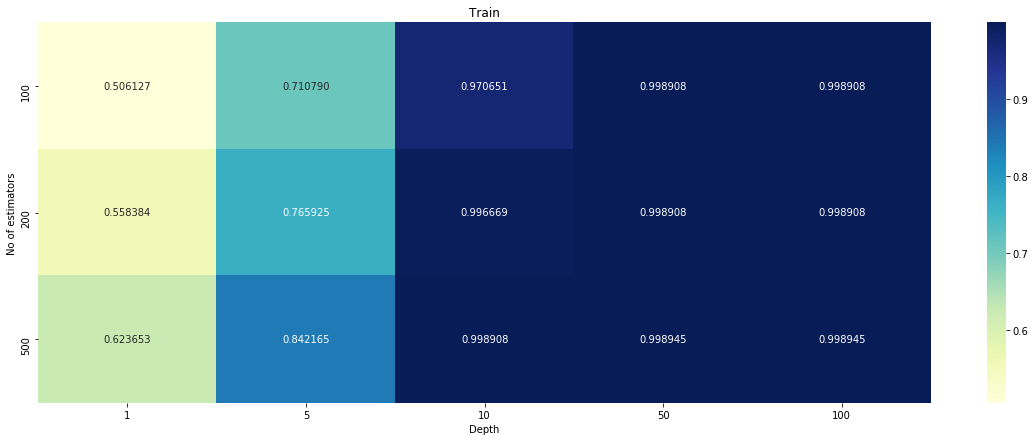

best estimators = 500 and depth = 5


In [36]:
best_estimator,best_depth = performHyperParameterTuningX(train,cv,test)

-------------------- Confusion matrix --------------------


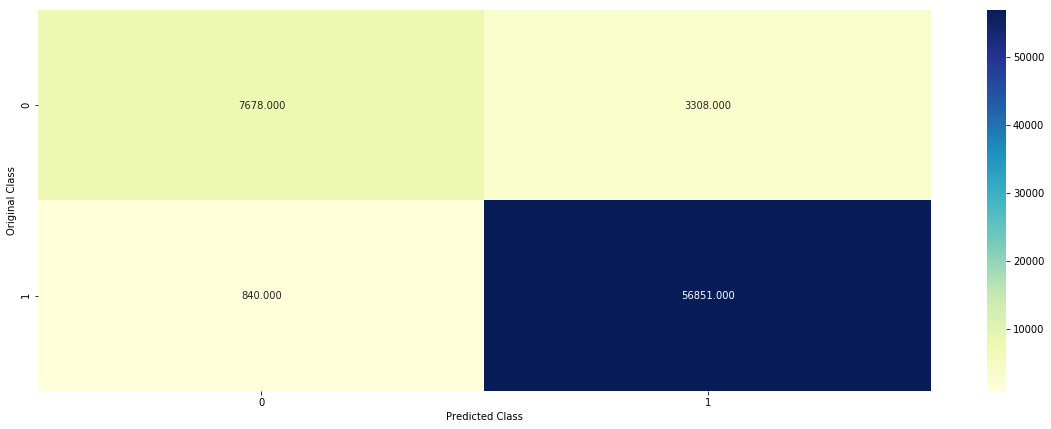

For values of best estimator =  500 best depth =  5 The AUC is: 0.8421645828438401
For values of best estimator =  500 best depth =  5 The AUC is: 0.7030454406325939
-------------------- Confusion matrix --------------------


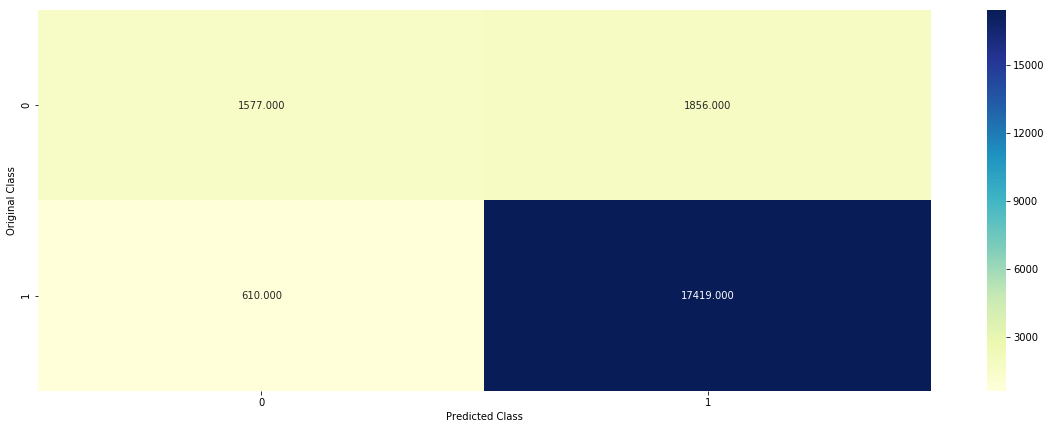

For values of best estimator =  500 best depth =  5 The AUC is: 0.7127653044726449


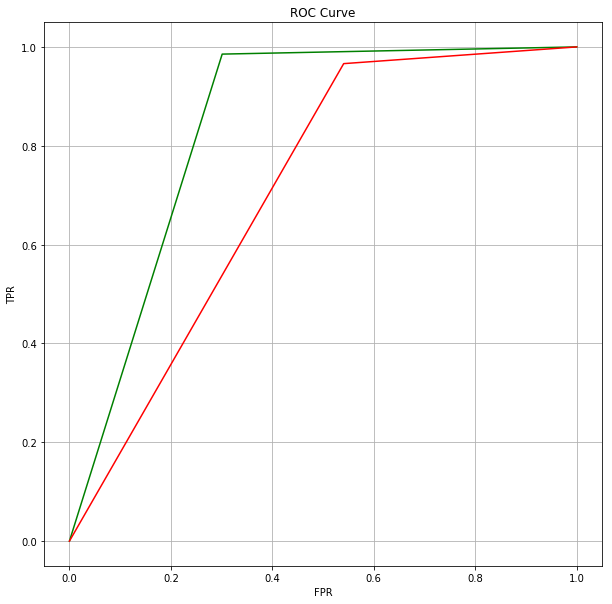

In [37]:
clf = bestModelX(train,cv,test,best_estimator,best_depth)

# [6] Conclusions

| Vectorizer | Algorithm | Depth | min_samples_split | AUC  |
|------------|-----------|-------|-------------------|------|
| BOW        | RF        | 100   | 500               | 0.65 |
| TFIDF      | RF        | 100   | 500               | 0.65 |
| AvgW2V     | RF        | 100   | 50                | 0.65 |
| TFIDFW2V   | RF        | 100   | 50                | 0.62 |
| BOW        | XgBoost   | 500   | 5                 | 0.77 |
| TFIDF      | XgBoost   | 500   | 50                | 0.79 |
| AvgW2V     | XgBoost   | 500   | 5                 | 0.74 |
| TFIDFW2V   | XgBoost   | 500   | 5                 | 0.71 |